In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

In [134]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord):
    max_len=10
    records = list(tf.python_io.tf_record_iterator(tfrecord))
    rec_len = len(records)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1
    j = 0

    laugh_labels = [16, 17, 18, 19, 20, 21]
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            laugh_bin = any((True for x in example_label if x in laugh_labels))
            y.append(laugh_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, y

In [135]:
g = data_generator(32,'bal_laugh_subset.tfrecord')
x, y = next(g)

In [141]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM

inp = keras.Input((None, 128))
x = BatchNormalization()(inp)
x = Dropout(.5)(x)
rnn = LSTM(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(rnn)

model = Model(input=inp, output=output)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
batch_size=32
train_gen = data_generator(batch_size,'bal_laugh_subset.tfrecord')
val_gen = data_generator(batch_size,'eval_laugh_subset.tfrecord')

model.fit_generator(train_gen,steps_per_epoch=212,epochs=40,validation_data=val_gen,validation_steps=586//32)

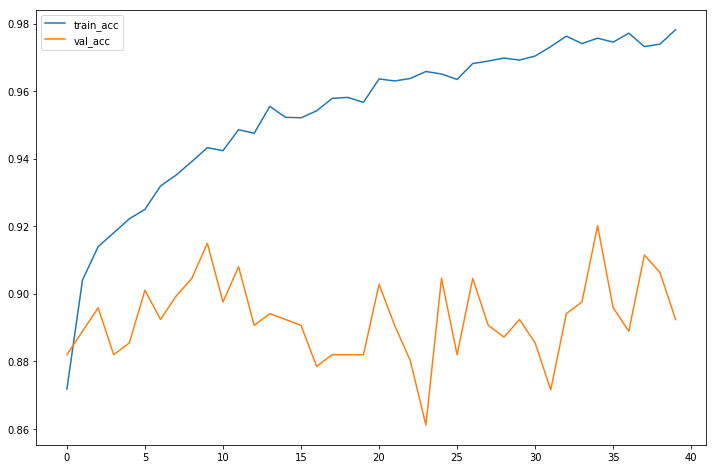

In [152]:
plt.plot(model.history.history['acc'], label='train_acc')
plt.plot(model.history.history['val_acc'], label='val_acc')
plt.legend()

In [153]:
model.save('Models/LSTM_')

In [88]:
inp = keras.Input((None, 128))
hidden = Dense(32)(inp)
output = Dense(1, activation='sigmoid')(hidden)

model = Model(input=inp, output=output)

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [89]:
batch_size=32
train_gen = data_generator(batch_size,'bal_laugh_subset.tfrecord')
val_gen = data_generator(batch_size,'eval_laugh_subset.tfrecord')

model.fit_generator(train_gen,steps_per_epoch=10000//batch_size,epochs=10,validation_data=val_gen,validation_steps=586//32)

Epoch 1/10


ValueError: Error when checking target: expected dense_13 to have 3 dimensions, but got array with shape (32, 1)

In [27]:
def tf_map(record_string):
    with tf.Session() as sess:
        record_string = sess.run(record_string)
    print(record_string)
    #tf_seq_example = tf.train.SequenceExample.FromString(record_string)
    tf_seq_example = tf.decode_raw(record_string,tf.int64)
    print(tf.train.SequenceExample.FromString(tf_seq_example))
    labels = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
                         
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
    audio_frame = []
    for i in range(n_frames):
        audio_frame.append(tf.cast(tf.decode_raw(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                 feature[i].bytes_list.value[0],tf.uint8
                                                ),tf.float32))
    return audio_frame, labels

In [ ]:
batch_size = 32

dataset = tf.data.TFRecordDataset(['bal_laugh_subset.tfrecord'])
dataset.map(tf_map)
dataset  = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()

In [7]:
with tf.Session() as sess:
    sess.run(iterator.get_next())

In [18]:
tf.parse_single_sequence_example

tf.string

In [43]:
def _parse_function(example_proto):
    #context_features = {'labels': tf.VarLenFeature(tf.int64)}
    context_features = {}
    sequence_features = {'audio_embedding': tf.FixedLenSequenceFeature([],tf.string)}
    con_f, seq_f = tf.parse_single_sequence_example(example_proto, context_features=context_features,
                                                        sequence_features=sequence_features)
    
    n_frames = seq_f['audio_embedding'].shape[0]
    audio_frame = []
    for i in range(n_frames):
        audio_frame.append(tf.cast(tf.decode_raw(seq_f['audio_embedding'].
                                                 feature[i].bytes_list.value[0],tf.uint8
                                                ),tf.float32))
    return audio_frame#, con_f['labels']

# Creates a dataset that reads all of the examples from two files, and extracts
# the image and label features.
filenames = ['bal_laugh_subset.tfrecord']
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(_parse_function)

TypeError: __index__ returned non-int (type NoneType)

In [ ]:
dataset  = dataset.batch(32)
iterator = dataset.make_one_shot_iterator()
with tf.Session() as sess:
    d = sess.run(iterator.get_next())
    print(d)

In [16]:
tf.train.Int64List.dtype

AttributeError: type object 'Int64List' has no attribute 'dtype'

In [ ]:
list(tf.python_io.tf_record_iterator('bal_laugh_subset.tfrecord'))